# Import Libraries


In [1]:
import os
import shutil

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import numpy as np
import pandas as pd

import wandb
from wandb.keras import WandbCallback

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from utils import create_model, fine_tune, augment_images, flatten_datasets
from config import config, models

import matplotlib.pyplot as plt

wandb: ERROR Unable to patch Tensorflow/Keras
exception while trying to patch_tf_keras
Traceback (most recent call last):
  File "/home/lorenzoquerol/miniconda3/envs/wssv-recognition/lib/python3.9/site-packages/wandb/integration/keras/keras.py", line 86, in patch_tf_keras
    from keras.engine import training
  File "/home/lorenzoquerol/miniconda3/envs/wssv-recognition/lib/python3.9/site-packages/keras/engine/training.py", line 29, in <module>
    from keras.dtensor import layout_map as layout_map_lib
  File "/home/lorenzoquerol/miniconda3/envs/wssv-recognition/lib/python3.9/site-packages/keras/dtensor/layout_map.py", line 24, in <module>
    from keras.dtensor import dtensor_api as dtensor
ImportError: cannot import name 'dtensor_api' from 'keras.dtensor' (/home/lorenzoquerol/miniconda3/envs/wssv-recognition/lib/python3.9/site-packages/keras/dtensor/__init__.py)
wandb: ERROR Unable to patch Tensorflow/Keras
exception while trying to patch_tf_keras
Traceback (most recent call last):
  

# Prepare Training Data

Our data will be split into 80% training, and holding out 20% for testing later on. The training set we will be used for 5-fold cross validation during model fitting, so our training set will be further split into training and validation.


In [2]:
data_dir = "dataset/2-cropped-v3"

train_set, test_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    seed=config["seed_value"],
    image_size=config["img_shape"],
    batch_size=config["batch_size"],
    label_mode="categorical",
    subset="both",
)

train_images, train_labels = flatten_datasets(train_set)

Found 447 files belonging to 2 classes.
Using 358 files for training.
Using 89 files for validation.


# Defining the Base Model

This project will be using MobileNetV3-Small (1) and EfficientNetV2-B0 (2). We can easily get this from the TensorFlow API. Let's set a `flag` variable so we can easily set which model we want to test with.


In [3]:
flag = 1
base_model = models[flag]["base_model"]
model_name = models[flag]["model_name"]

In [4]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  230


In [5]:
fold = 5
df = pd.read_csv(f"results/MobilenetV3small/fold_{fold}.csv")
print(len(df))

150


# Fitting the Model

We define our cross validation strategy as `StratifiedKFold` and set the splits to 5 to ensure that the distribution of image samples per split remains equal all throughout to counter class imbalance.


In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=config["seed_value"])

# Loop over the dataset to create separate folds
for i, (train_idx, valid_idx) in enumerate(
    cv.split(train_images, np.argmax(train_labels, axis=1))
):
    print(f"Fold {i + 1}")

    model = fine_tune(base_model, config, 224)

    # Load the weights from the checkpoint
    checkpoints_path = f"checkpoints/{model_name}/fold_{i+1}"
    latest_checkpoint = tf.train.latest_checkpoint(checkpoints_path)
    last_epoch = len(pd.read_csv(f"results/{model_name}/fold_{i+1}.csv"))

    model.load_weights(latest_checkpoint)

    # Get the training and validation data
    X_train, y_train = train_images[train_idx], train_labels[train_idx]
    X_valid, y_valid = train_images[valid_idx], train_labels[valid_idx]

    # Augment ONLY training data
    X_train, y_train = augment_images(X_train, y_train, 5)

    # Compute weights
    weights = compute_class_weight(
        class_weight="balanced", classes=np.unique([0, 1]), y=y_train.argmax(axis=1)
    )
    weights = dict(zip(np.unique([0, 1]), weights))

    # Define checkpoint path and checkpoint callback
    path = f"checkpoints/fine-tune/{model_name}/fold_{i+1}"
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

    # Save the weights using the `checkpoint_path` format
    checkpoint_path = path + "/cp-{epoch:04d}.ckpt"
    model.save_weights(checkpoint_path.format(epoch=0))

    # Define filename for CSV log
    log_path = f"results/fine-tune/{model_name}"
    filename = log_path + f"/fold_{i+1}.csv"

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            verbose=1,
        ),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10),
        tf.keras.callbacks.CSVLogger(filename, separator=",", append=False),
    ]

    # Fit the model on the train set and evaluate on the validation set
    model.fit(
        X_train,
        y_train,
        batch_size=config["batch_size"],
        initial_epoch=last_epoch,
        epochs=last_epoch + (300 - last_epoch),
        class_weight=weights,
        validation_data=(X_valid, y_valid),
        verbose=1,
        callbacks=callbacks,
    )

Fold 1


Epoch 151/300
27/27 [==============================] - ETA: 0s - loss: 0.1248 - precision: 0.9464 - recall: 0.9464 - f1_score: 0.9520 - false_negatives: 92.0000 - true_positives: 1624.0000 - false_positives: 92.0000 - true_negatives: 1624.0000
Epoch 151: val_loss improved from inf to 0.11872, saving model to checkpoints/fine-tune/MobilenetV3small/fold_1/cp-0151.ckpt
27/27 [==============================] - 7s 80ms/step - loss: 0.1248 - precision: 0.9464 - recall: 0.9464 - f1_score: 0.9520 - false_negatives: 92.0000 - true_positives: 1624.0000 - false_positives: 92.0000 - true_negatives: 1624.0000 - val_loss: 0.1187 - val_precision: 0.9583 - val_recall: 0.9583 - val_f1_score: 0.9562 - val_false_negatives: 3.0000 - val_true_positives: 69.0000 - val_false_positives: 3.0000 - val_true_negatives: 69.0000
Epoch 152/300
27/27 [==============================] - ETA: 0s - loss: 0.1277 - precision: 0.9522 - recall: 0.9522 - f1_score: 0.9568 - false_negatives: 82.0000 - true_positives: 1634.0000 

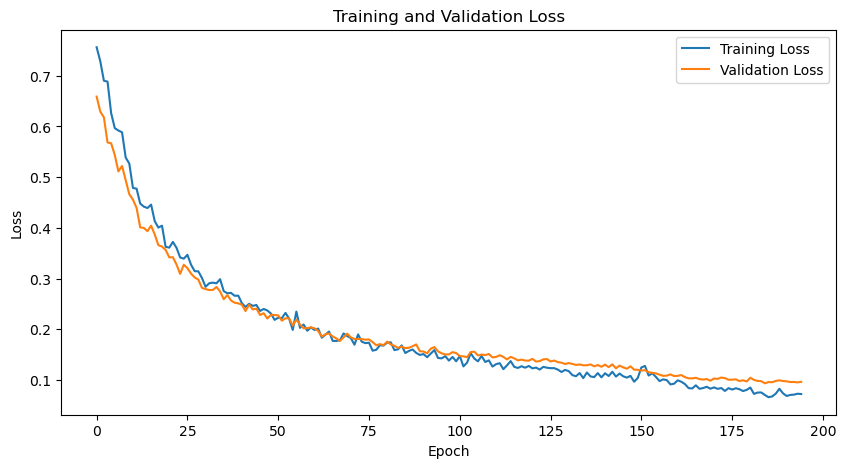

In [14]:
# get original training results
fold = 1
df = pd.read_csv(f"results/MobilenetV3small/fold_{fold}.csv")
fine_tuned_df = pd.read_csv(f"results/fine-tune/MobilenetV3small/fold_{fold}.csv")

# get combined results
df = pd.concat([df, fine_tuned_df], ignore_index=True)

# plot training results
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["loss"], label="Training Loss")
plt.plot(df["epoch"], df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()